# Introduction

The purpose of this notebook is to try a few simple probe similarity metrics I can use to create a pairwise comparison table between probes

In [ ]:
import importlib
import gc
import ptycho_torch.datagen
import ptycho_torch.reassembly
import ptycho_torch.helper
import ptycho_torch.dataloader
import ptycho_torch.patch_generator
importlib.reload(ptycho_torch.reassembly)
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho_torch.dataloader)
importlib.reload(ptycho_torch.patch_generator)

<module 'ptychopinn_torch.patch_generator' from '/local/CDI-PINN/ptychopinn_torch/patch_generator.py'>

In [ ]:
from ptycho_torch.reassembly import reconstruct_image, reassemble_multi_channel
from ptycho_torch.patch_generator import get_fixed_quadrant_neighbors_c4
import mlflow.pytorch
from mlflow import MlflowClient
import matplotlib.pyplot as plt
import torch
import numpy as np
from ptycho_torch.utils import load_all_configs_from_mlflow, update_existing_config
import os
from ptycho_torch.helper import center_crop

In [ ]:
from ptycho_torch.train import print_auto_logged_info
from ptycho_torch.config_params import ModelConfig, TrainingConfig, DataConfig, InferenceConfig
from ptycho_torch.config_params import update_existing_config
from ptycho_torch.dataloader import TensorDictDataLoader, PtychoDataset, Collate
from glob import glob

# Probe Directory/file setup

In [31]:
# Get all directories starting with "pinn"
pinn_dirs = glob("../../data/pinn*/", recursive=False)

# Filter out those ending with "_supervised"
filtered_dirs = [d for d in pinn_dirs if not d.rstrip('/').endswith('_supervised')]
filtered_dirs.sort()

In [33]:
def get_probe_list(dir_list):
    probe_names = []
    probe_list = []
    #Iterate through all npz files
    for subdir in dir_list:
        probe_name = subdir.split('/')[-2][5:]

        temp_file = glob(subdir + '*.npz')[0]
        loaded_temp_file = np.load(temp_file)
        temp_probe = loaded_temp_file['probeGuess']

        probe_names.append(probe_name)
        probe_list.append(temp_probe)

    return probe_names, probe_list

In [34]:
# Running simple get probe function
probe_names, probe_list = get_probe_list(filtered_dirs)

# Probe cross-comparison analysis

In [35]:
def complex_correlation(probe1, probe2):
    # Normalize to unit energy
    probe1_norm = probe1 / np.sqrt(np.sum(np.abs(probe1)**2))
    probe2_norm = probe2 / np.sqrt(np.sum(np.abs(probe2)**2))
    
    # Complex correlation
    correlation = np.sum(probe1_norm * np.conj(probe2_norm))
    return np.abs(correlation)  # Magnitude gives similarity

In [36]:
# Compute similarities
n = len(probe_names)
similarity_matrix = np.empty((n, n))

for i in range(n):
    similarity_matrix[i,i] = 1
    for j in range(i+1,n):
        probe1 = probe_list[i]
        probe2 = probe_list[j]
        corr = complex_correlation(probe1, probe2)

        similarity_matrix[i,j] = corr
        similarity_matrix[j,i] = corr


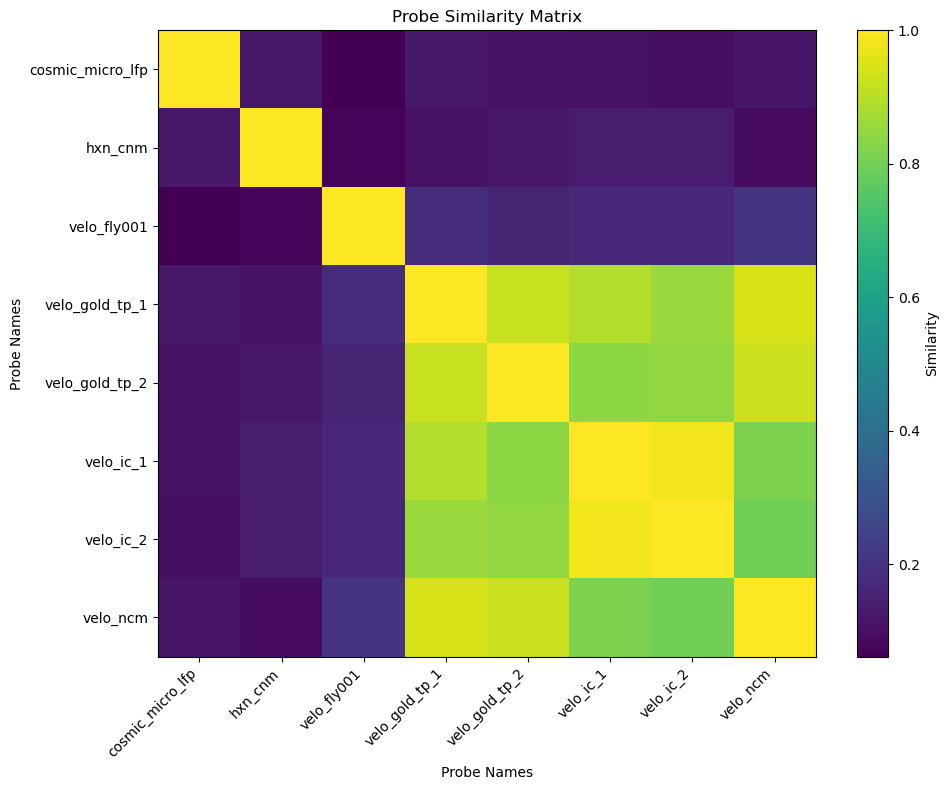

In [37]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Display the similarity matrix
im = ax.imshow(similarity_matrix, cmap='viridis', aspect='auto')

# Set the ticks to correspond to each probe
ax.set_xticks(range(len(probe_names)))
ax.set_yticks(range(len(probe_names)))

# Set the labels
ax.set_xticklabels(probe_names, rotation=45, ha='right')
ax.set_yticklabels(probe_names, rotation=0)  # horizontal

# Add labels
ax.set_xlabel('Probe Names')
ax.set_ylabel('Probe Names')
ax.set_title('Probe Similarity Matrix')

# Add colorbar
plt.colorbar(im, ax=ax, label='Similarity')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()